#Multivariate LSTM for Indian Air Quality — Parquet/CSV (Colab)

This notebook trains a **global, multivariate, multi-horizon LSTM** for forecasting multiple pollutants across multiple Indian stations/cities.

In [7]:
# Minimal installs (pyarrow for Parquet). Quiet output for a clean look.
!pip -q install pandas numpy scikit-learn tensorflow matplotlib joblib pyarrow > /dev/null
import tensorflow as tf, numpy as np, pandas as pd
print("TF:", tf.__version__)

TF: 2.19.0


In [ ]:
# ============================
# =========== CONFIG =========
# ============================
DATA_PATH = "data/India_complete.parquet"   # or "India_complete.csv"

# Windowing & horizon
INPUT_STEPS = 24
PRED_STEPS  = 6

# Chronological split
TRAIN_FRAC = 0.65
VAL_FRAC   = 0.15
TEST_FRAC  = 0.10
OOS_FRAC   = 0.10

# Stride to thin windows on huge data
STRIDE = 1

# Model
HIDDEN_UNITS = [128, 64]
DROPOUT = 0.2
BATCH_SIZE = 128
EPOCHS = 50
LEARNING_RATE = 1e-3

ARTIFACT_DIR = "/content/india_lstm_artifacts"
import os
os.makedirs(ARTIFACT_DIR, exist_ok=True)
print("Artifacts ->", ARTIFACT_DIR)
print("GPU:", tf.config.list_physical_devices('GPU'))

Artifacts -> /content/india_lstm_artifacts
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Bring your data
Choose **one** of the options below.

### Upload `India_complete.parquet` or `India_complete.csv`

In [3]:
from google.colab import files
print("Upload India_complete.parquet or India_complete.csv")
uploaded = files.upload()
print("Uploaded:", list(uploaded.keys()))


Upload india_complete.parquet or india_complete.csv


Saving India_complete.parquet to India_complete.parquet
Uploaded: ['India_complete.parquet']


### Actual Code

In [4]:
import gc, pathlib, json, joblib, matplotlib.pyplot as plt, re
from typing import Optional, List
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Reshape
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import pandas as pd
import numpy as np
import tensorflow as tf

TIME_COL_CANDIDATES = ["datetime", "timestamp", "date_time", "date", "time", "Date", "Datetime"]
STATION_COL_CANDIDATES = ["station", "site", "location", "city", "City", "Station", "Site", "Location", "district", "state"]

POLLUTANT_PATTERNS = {
    "PM2.5": r"\bpm\s*2\.?5\b|\bpm2\.?5\b|\bpm_?2_?5\b",
    "PM10":  r"\bpm\s*10\b|\bpm10\b|\bpm_?10\b",
    "NO2":   r"\bno2\b|\bnitrogen\s*dioxide\b",
    "NO":    r"\bno\b(?![a-z])",
    "SO2":   r"\bso2\b|\bsulfur\s*dioxide\b|\bsulphur\s*dioxide\b",
    "O3":    r"\bo3\b|\bozone\b",
    "CO":    r"\bco\b(?![a-z])|\bcarbon\s*monoxide\b",
    "NH3":   r"\bnh3\b|\bammonia\b",
    "Pb":    r"\bpb\b|\blead\b",
}

def find_time_column(df: pd.DataFrame) -> str:
    for c in TIME_COL_CANDIDATES:
        if c in df.columns:
            dt = pd.to_datetime(df[c], errors="coerce", infer_datetime_format=True)
            if dt.notna().mean() > 0.8:
                return c
    for c in df.columns:
        if df[c].dtype == "O":
            dt = pd.to_datetime(df[c], errors="coerce", infer_datetime_format=True)
            if dt.notna().mean() > 0.8:
                return c
    raise ValueError("Could not detect a timestamp column.")

def find_station_column(df: pd.DataFrame) -> Optional[str]:
    for c in STATION_COL_CANDIDATES:
        if c in df.columns:
            return c
    return None

def detect_pollutant_columns(df: pd.DataFrame) -> List[str]:
    found = []
    for col in df.columns:
        c = str(col).lower().strip()
        for _, pattern in POLLUTANT_PATTERNS.items():
            if re.search(pattern, c, flags=re.IGNORECASE):
                found.append(col)
                break
    for col in df.columns:
        c = str(col).lower().strip()
        if c in ["pm25", "pm2_5", "pm-2.5", "pm2.5"] and col not in found:
            found.append(col)
    if not found:
        raise ValueError("No pollutant columns found. Please rename or extend patterns.")
    return list(dict.fromkeys(found))

def infer_frequency(ts: pd.Series):
    s = ts.sort_values().drop_duplicates()
    if len(s) < 3: return None
    d = s.diff().dropna()
    return d.median() if len(d) else None

def choose_resample_rule(median_delta):
    if median_delta is None: return None
    seconds = median_delta.total_seconds()
    if seconds <= 90*60: return "1h"
    if seconds <= 3*3600: return "2h"
    if seconds <= 12*3600: return "6h"
    if seconds <= 36*3600: return "1d"
    return "7d"

def safe_numeric(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    for c in out.columns:
        if not np.issubdtype(out[c].dtype, np.number):
            out[c] = pd.to_numeric(out[c], errors="coerce")
    return out

In [8]:
# ---------- READ DATA ----------
print("Reading:", DATA_PATH)
path = pathlib.Path(DATA_PATH)
if path.suffix.lower() in {".parquet", ".pq"}:
    df = pd.read_parquet(path)
else:
    df = pd.read_csv(path)
print("Raw shape:", df.shape)

float64_cols = df.select_dtypes(include=["float64"]).columns
int64_cols   = df.select_dtypes(include=["int64"]).columns
if len(float64_cols): df[float64_cols] = df[float64_cols].astype("float32")
if len(int64_cols):   df[int64_cols]   = df[int64_cols].astype("int32")

time_col = find_time_column(df)
df[time_col] = pd.to_datetime(df[time_col], errors="coerce", infer_datetime_format=True)
station_col = find_station_column(df)
pol_cols = detect_pollutant_columns(df)

df = df.dropna(subset=[time_col]).sort_values(time_col).reset_index(drop=True)

id_like = [c for c in df.columns if re.search(r"id$|_id$|^id$", str(c), flags=re.IGNORECASE)]
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [c for c in df.columns if c in set(pol_cols + numeric_cols) and c not in id_like]

print("Time:", time_col, "| Station:", station_col)
print("Pollutants:", pol_cols)
print("Feature count (pre-resample):", len(feature_cols))

Reading: India_complete.parquet
Raw shape: (2589083, 17)


/tmp/ipython-input-1752053742.py:30: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dt = pd.to_datetime(df[c], errors="coerce", infer_datetime_format=True)
/tmp/ipython-input-458790581.py:16: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[time_col] = pd.to_datetime(df[time_col], errors="coerce", infer_datetime_format=True)


Time: datetime | Station: City
Pollutants: ['PM2.5', 'PM10', 'NO', 'NO2', 'NH3', 'CO', 'SO2', 'O3']
Feature count (pre-resample): 10


In [9]:
# ---------- CLEAN, RESAMPLE (NUMERIC-ONLY), ONE-HOT ----------
if station_col is None:
    df_ffill = df.sort_values(time_col).copy()
    df_ffill[feature_cols] = df_ffill[feature_cols].ffill().bfill()
else:
    parts = []
    for st, g in df.groupby(station_col, as_index=False):
        g = g.sort_values(time_col)
        g[feature_cols] = g[feature_cols].ffill().bfill()
        parts.append(g)
    df_ffill = pd.concat(parts, ignore_index=True).sort_values([station_col, time_col])

def resample_numeric_only(g):
    med = infer_frequency(g[time_col]); rule = choose_resample_rule(med)
    use_cols = [c for c in feature_cols if c in g.columns]
    if rule:
        out = (g[[time_col] + use_cols].set_index(time_col).resample(rule).mean(numeric_only=True).reset_index())
    else:
        out = g[[time_col] + use_cols].copy()
    return out

if station_col is None:
    df_res = resample_numeric_only(df_ffill)
else:
    outs = []
    for st, g in df_ffill.groupby(station_col, as_index=False):
        tmp = resample_numeric_only(g)
        tmp[station_col] = st
        outs.append(tmp)
    df_res = pd.concat(outs, ignore_index=True).sort_values([station_col, time_col])

if station_col is None:
    df_res[feature_cols] = df_res[feature_cols].ffill().bfill()
else:
    df_res = df_res.sort_values([station_col, time_col])
    for c in feature_cols:
        df_res[c] = df_res.groupby(station_col)[c].ffill().bfill()

if station_col is not None:
    dummies = pd.get_dummies(df_res[station_col], prefix="STN", drop_first=False)
    feature_cols_full = [c for c in feature_cols if c in df_res.columns] + list(dummies.columns)
    df_model = pd.concat([df_res[[time_col, station_col] + [c for c in feature_cols if c in df_res.columns]], dummies], axis=1)
else:
    feature_cols_full = [c for c in feature_cols if c in df_res.columns]
    df_model = df_res[[time_col] + feature_cols_full]

target_cols = [c for c in pol_cols if c in df_model.columns]
if not target_cols:
    raise ValueError("No target pollutant columns retained after processing.")
print("Final feature count:", len(feature_cols_full))
print("Targets:", target_cols[:10], "...")

Final feature count: 36
Targets: ['PM2.5', 'PM10', 'NO', 'NO2', 'NH3', 'CO', 'SO2', 'O3'] ...


In [10]:
# ---------- SPLIT & SEQUENCES (with OOS) ----------
times_sorted = df_model[time_col].sort_values().unique()
n = len(times_sorted)

t_train_end = times_sorted[int(n * TRAIN_FRAC) - 1]
t_val_end   = times_sorted[int(n * (TRAIN_FRAC + VAL_FRAC)) - 1]
t_test_end  = times_sorted[int(n * (TRAIN_FRAC + VAL_FRAC + TEST_FRAC)) - 1]

print("Cutoffs -> train:", t_train_end, "| val:", t_val_end, "| test:", t_test_end, "| oos: remainder")

scalers = {"X": StandardScaler(), "y": StandardScaler()}

feats_train, targs_train = [], []
stations = [None] if station_col is None else list(df_model[station_col].dropna().unique())
for st in stations:
    g = df_model if station_col is None else df_model[df_model[station_col] == st]
    m = g[time_col] <= t_train_end
    feats_train.append(g.loc[m, feature_cols_full].values)
    targs_train.append(g.loc[m, target_cols].values)
scalers["X"].fit(np.vstack([a for a in feats_train if a.size]))
scalers["y"].fit(np.vstack([a for a in targs_train if a.size]))

def build_windows(g):
    feat = scalers["X"].transform(g[feature_cols_full].values)
    targ = scalers["y"].transform(g[target_cols].values)
    total = INPUT_STEPS + PRED_STEPS
    Xs, Ys, ends = [], [], []
    for i in range(0, len(g) - total + 1, STRIDE):
        Xs.append(feat[i:i+INPUT_STEPS, :])
        Ys.append(targ[i+INPUT_STEPS:i+total, :])
        ends.append(g[time_col].iloc[i+INPUT_STEPS-1])
    return np.array(Xs), np.array(Ys), np.array(ends)

Xtr, Ytr, Xva, Yva, Xte, Yte, Xoo, Yoo = [], [], [], [], [], [], [], []
for st in stations:
    g = df_model if station_col is None else df_model[df_model[station_col]==st]
    g = g.sort_values(time_col)
    X, Y, ends = build_windows(g)
    tr = ends <= t_train_end
    va = (ends > t_train_end) & (ends <= t_val_end)
    te = (ends > t_val_end) & (ends <= t_test_end)
    oo = ends > t_test_end
    Xtr.append(X[tr]); Ytr.append(Y[tr])
    Xva.append(X[va]); Yva.append(Y[va])
    Xte.append(X[te]); Yte.append(Y[te])
    Xoo.append(X[oo]); Yoo.append(Y[oo])

X_train = np.concatenate(Xtr) if Xtr else np.zeros((0,INPUT_STEPS,len(feature_cols_full)))
y_train = np.concatenate(Ytr) if Ytr else np.zeros((0,PRED_STEPS,len(target_cols)))
X_val   = np.concatenate(Xva) if Xva else np.zeros((0,INPUT_STEPS,len(feature_cols_full)))
y_val   = np.concatenate(Yva) if Yva else np.zeros((0,PRED_STEPS,len(target_cols)))
X_test  = np.concatenate(Xte) if Xte else np.zeros((0,INPUT_STEPS,len(feature_cols_full)))
y_test  = np.concatenate(Yte) if Yte else np.zeros((0,PRED_STEPS,len(target_cols)))
X_oos   = np.concatenate(Xoo) if Xoo else np.zeros((0,INPUT_STEPS,len(feature_cols_full)))
y_oos   = np.concatenate(Yoo) if Yoo else np.zeros((0,PRED_STEPS,len(target_cols)))

print("X_train:", X_train.shape, "| X_val:", X_val.shape, "| X_test:", X_test.shape, "| X_oos:", X_oos.shape)

Cutoffs -> train: 2018-07-29 04:00:00 | val: 2019-05-26 09:00:00 | test: 2019-12-13 04:00:00 | oos: remainder
X_train: (116890, 24, 36) | X_val: (44155, 24, 36) | X_test: (34329, 24, 36) | X_oos: (40343, 24, 36)


In [11]:
# ---------- MODEL ----------
tf.keras.backend.clear_session()
n_features = X_train.shape[-1]
n_targets  = y_train.shape[-1]

model = Sequential([
    LSTM(HIDDEN_UNITS[0], return_sequences=True, input_shape=(INPUT_STEPS, n_features)),
    Dropout(DROPOUT),
    LSTM(HIDDEN_UNITS[1], return_sequences=False),
    Dropout(DROPOUT),
    Dense(PRED_STEPS * n_targets),
    Reshape((PRED_STEPS, n_targets)),
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss="mse", metrics=[tf.keras.metrics.MeanAbsoluteError(name="mae")])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 128)        │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 48)             │         3,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 6, 8)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 137,008 (535.19 KB)

 Trainable params: 137,008 (535.19 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# ---------- TRAIN ----------
ckpt_path = f"{ARTIFACT_DIR}/best_lstm.keras"
callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6, verbose=1),
    ModelCheckpoint(filepath=ckpt_path, monitor="val_loss", save_best_only=True, verbose=1)
]
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val) if X_val.shape[0] else None,
    epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=2, callbacks=callbacks
)
model.save(f"{ARTIFACT_DIR}/final_lstm.keras")
joblib.dump(scalers, f"{ARTIFACT_DIR}/scalers.joblib")
json.dump(target_cols, open(f"{ARTIFACT_DIR}/target_cols.json","w"))
json.dump([str(c) for c in feature_cols_full], open(f"{ARTIFACT_DIR}/feature_cols.json","w"))

Epoch 1/50

Epoch 1: val_loss improved from inf to 0.41713, saving model to /content/india_lstm_artifacts/best_lstm.keras
914/914 - 16s - 18ms/step - loss: 0.3715 - mae: 0.3055 - val_loss: 0.4171 - val_mae: 0.2734 - learning_rate: 1.0000e-03
Epoch 2/50

Epoch 2: val_loss improved from 0.41713 to 0.37233, saving model to /content/india_lstm_artifacts/best_lstm.keras
914/914 - 8s - 8ms/step - loss: 0.2896 - mae: 0.2612 - val_loss: 0.3723 - val_mae: 0.2469 - learning_rate: 1.0000e-03
Epoch 3/50

Epoch 3: val_loss improved from 0.37233 to 0.35204, saving model to /content/india_lstm_artifacts/best_lstm.keras
914/914 - 7s - 8ms/step - loss: 0.2722 - mae: 0.2523 - val_loss: 0.3520 - val_mae: 0.2439 - learning_rate: 1.0000e-03
Epoch 4/50

Epoch 4: val_loss improved from 0.35204 to 0.33719, saving model to /content/india_lstm_artifacts/best_lstm.keras
914/914 - 8s - 8ms/step - loss: 0.2640 - mae: 0.2482 - val_loss: 0.3372 - val_mae: 0.2380 - learning_rate: 1.0000e-03
Epoch 5/50

Epoch 5: val_l

Per-pollutant error table (MAE/RMSE):


,pollutant,set,MAE,RMSE
0,CO,OOS,1.143187,5.141309
1,CO,TEST,1.476111,6.490419
2,NH3,OOS,5.260827,10.636084
3,NH3,TEST,4.727546,10.256497
4,NO,OOS,9.596020,25.126303
5,NO,TEST,7.417405,17.225639
6,NO2,OOS,6.571690,10.418714
7,NO2,TEST,7.705733,16.032171
8,O3,OOS,9.388662,14.249743
9,O3,TEST,9.379277,14.987960


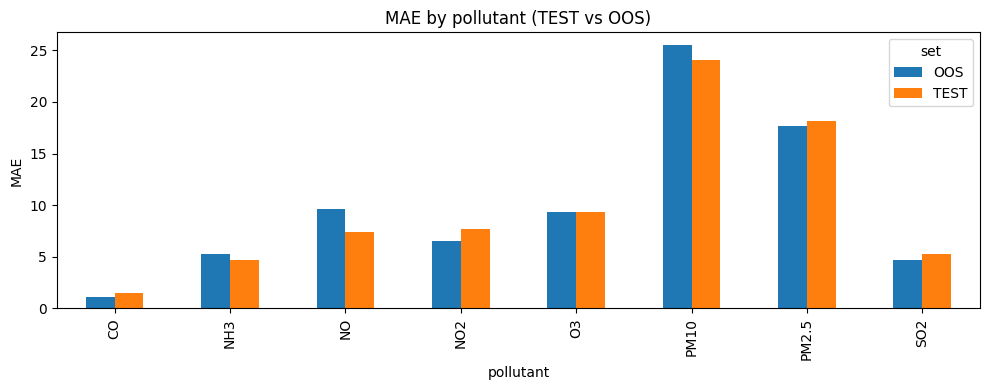

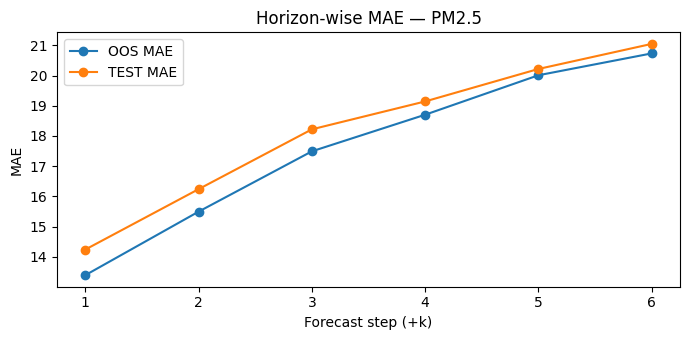

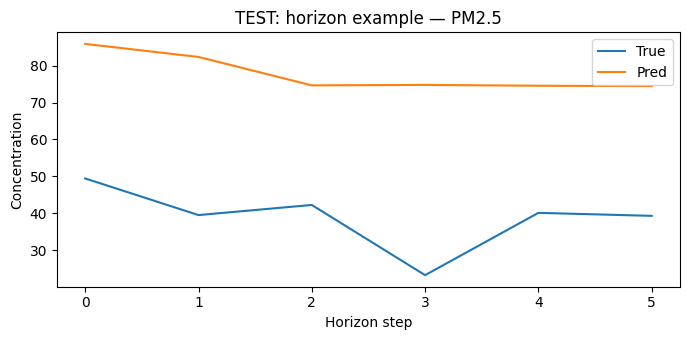

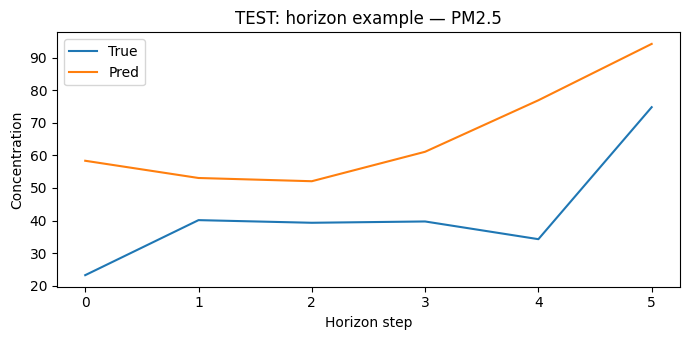

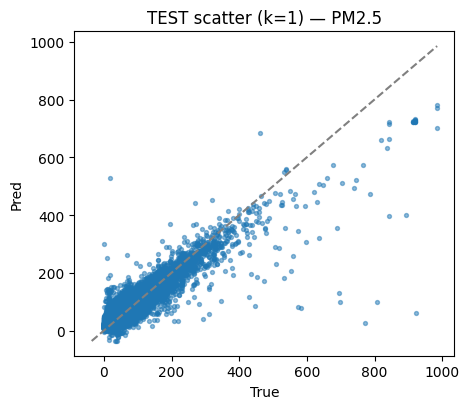

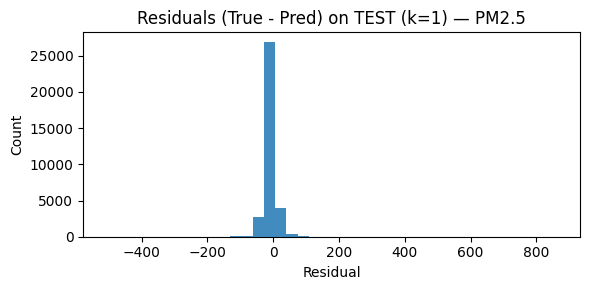

from matplotlib import pyplot as plt
_df_0['MAE'].plot(kind='hist', bins=20, title='MAE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['RMSE'].plot(kind='hist', bins=20, title='RMSE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('pollutant').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_3.groupby('set').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='MAE', y='RMSE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5['MAE'].plot(kind='line', figsize=(8, 4), title='MAE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_6['RMSE'].plot(kind='line', figsize=(8, 4), title='RMSE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['set'].value_counts()
    for x_label, grp in _df_7.groupby('pollutant')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('pollutant')
_ = plt.ylabel('set')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_8['pollutant'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_8, x='MAE', y='pollutant', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_9['set'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_9, x='MAE', y='set', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_10['pollutant'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_10, x='RMSE', y='pollutant', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_11['set'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_11, x='RMSE', y='set', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [13]:
# ---------- INLINE EVALUATION & PLOTS ----------
import matplotlib.pyplot as plt

def inv_scale_y(arr):
    if arr.size == 0:
        return arr
    flat = arr.reshape(-1, len(target_cols))
    inv  = scalers['y'].inverse_transform(flat)
    return inv.reshape(arr.shape)

def metrics_df(y_true, y_pred, label):
    if y_true.size == 0:
        return pd.DataFrame(columns=["pollutant","set","MAE","RMSE"])
    out = []
    for j, col in enumerate(target_cols):
        t = y_true[:,:,j].ravel()
        p = y_pred[:,:,j].ravel()
        mae = np.mean(np.abs(t - p))
        rmse = np.sqrt(np.mean((t - p)**2))
        out.append([col, label, mae, rmse])
    return pd.DataFrame(out, columns=["pollutant","set","MAE","RMSE"])

def horizon_metrics(y_true, y_pred, pollutant_idx=0, label="TEST"):
    rows = []
    for k in range(PRED_STEPS):
        t = y_true[:,k,pollutant_idx]
        p = y_pred[:,k,pollutant_idx]
        mae  = np.mean(np.abs(t - p))
        rmse = np.sqrt(np.mean((t - p)**2))
        rows.append([k+1, mae, rmse, label])
    return pd.DataFrame(rows, columns=["Horizon(+k)", "MAE", "RMSE", "set"])

def predict_and_inv(X):
    y = model.predict(X, verbose=0) if X.shape[0] else np.zeros((0,PRED_STEPS,len(target_cols)))
    return inv_scale_y(y)

y_pred_test = predict_and_inv(X_test); y_true_test = inv_scale_y(y_test)
y_pred_oos  = predict_and_inv(X_oos);  y_true_oos  = inv_scale_y(y_oos)

tbl_test = metrics_df(y_true_test, y_pred_test, "TEST")
tbl_oos  = metrics_df(y_true_oos,  y_pred_oos,  "OOS") if y_true_oos.size else pd.DataFrame(columns=tbl_test.columns)
tbl_all  = pd.concat([tbl_test, tbl_oos], ignore_index=True)

print("Per-pollutant error table (MAE/RMSE):")
display(tbl_all.sort_values(["pollutant","set"]).reset_index(drop=True))

pivot = tbl_all.pivot(index="pollutant", columns="set", values="MAE").fillna(np.nan)
ax = pivot.plot(kind="bar", figsize=(10,4))
ax.set_title("MAE by pollutant (TEST vs OOS)"); ax.set_ylabel("MAE"); plt.tight_layout(); plt.show()

idx_plot = target_cols.index("PM2.5") if "PM2.5" in target_cols else 0
hz_test = horizon_metrics(y_true_test, y_pred_test, pollutant_idx=idx_plot, label="TEST")
hz_all  = hz_test.copy()
if y_true_oos.size:
    hz_oos  = horizon_metrics(y_true_oos,  y_pred_oos,  pollutant_idx=idx_plot, label="OOS")
    hz_all  = pd.concat([hz_test, hz_oos])

plt.figure(figsize=(7,3.5))
for name, g in hz_all.groupby("set"):
    plt.plot(g["Horizon(+k)"], g["MAE"], marker="o", label=f"{name} MAE")
plt.title(f"Horizon-wise MAE — {target_cols[idx_plot]}")
plt.xlabel("Forecast step (+k)"); plt.ylabel("MAE"); plt.legend(); plt.tight_layout(); plt.show()

def plot_example_horizon(y_true, y_pred, pollutant_idx=0, example_idx=0, setname="TEST"):
    if y_true.size == 0: return
    plt.figure(figsize=(7,3.5))
    plt.plot(y_true[example_idx,:,pollutant_idx], label="True")
    plt.plot(y_pred[example_idx,:,pollutant_idx], label="Pred")
    plt.title(f"{setname}: horizon example — {target_cols[pollutant_idx]}")
    plt.xlabel("Horizon step"); plt.ylabel("Concentration")
    plt.legend(); plt.tight_layout(); plt.show()

plot_example_horizon(y_true_test, y_pred_test, pollutant_idx=idx_plot, example_idx=0, setname="TEST")
if y_true_test.shape[0] > 1:
    plot_example_horizon(y_true_test, y_pred_test, pollutant_idx=idx_plot, example_idx=1, setname="TEST")

if y_true_test.size:
    k = 0
    t = y_true_test[:,k,idx_plot].ravel(); p = y_pred_test[:,k,idx_plot].ravel()
    res = t - p
    plt.figure(figsize=(4.8,4.2))
    plt.scatter(t, p, s=8, alpha=0.5)
    lim = [min(t.min(), p.min()), max(t.max(), p.max())]
    plt.plot(lim, lim, ls="--", c="gray"); plt.xlabel("True"); plt.ylabel("Pred")
    plt.title(f"TEST scatter (k=1) — {target_cols[idx_plot]}"); plt.tight_layout(); plt.show()

    plt.figure(figsize=(6,3))
    plt.hist(res, bins=40, alpha=0.85)
    plt.title(f"Residuals (True - Pred) on TEST (k=1) — {target_cols[idx_plot]}")
    plt.xlabel("Residual"); plt.ylabel("Count"); plt.tight_layout(); plt.show()

,pollutant,set,R2
0,CO,OOS,0.444094
1,CO,TEST,0.469551
2,NH3,OOS,0.718272
3,NH3,TEST,0.720167
4,NO,OOS,0.595287
5,NO,TEST,0.483115
6,NO2,OOS,0.718984
7,NO2,TEST,0.758610
8,O3,OOS,0.718918
9,O3,TEST,0.720323


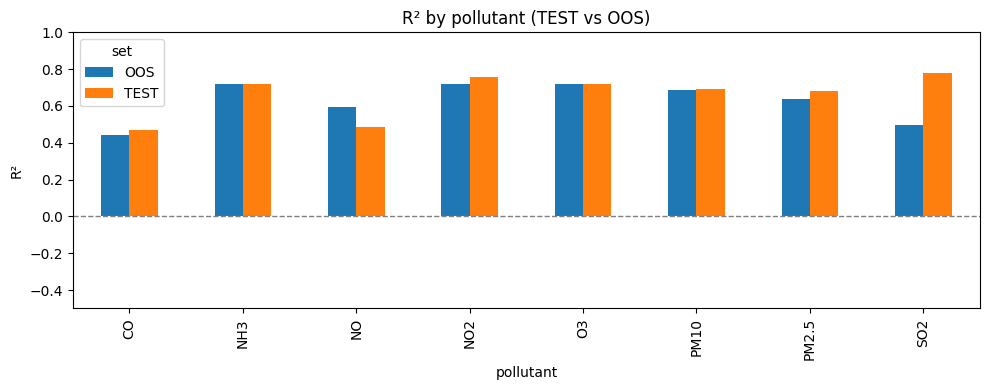

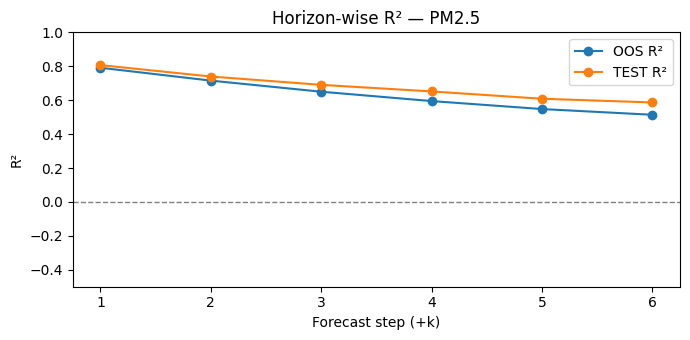

In [14]:
# ---------- R² per pollutant (TEST + OOS), plus horizon-wise R² ----------
import numpy as np, pandas as pd, matplotlib.pyplot as plt

def r2_1d(y_true_1d, y_pred_1d):
    """Basic R² = 1 - SSE/SST with safety for constant targets."""
    y_true_1d = np.asarray(y_true_1d).ravel()
    y_pred_1d = np.asarray(y_pred_1d).ravel()
    ss_res = np.sum((y_true_1d - y_pred_1d)**2)
    y_mean = np.mean(y_true_1d)
    ss_tot = np.sum((y_true_1d - y_mean)**2)
    return np.nan if ss_tot == 0 else (1.0 - ss_res/ss_tot)

def r2_table(y_true, y_pred, label):
    """
    R² per pollutant, aggregating across ALL horizons and samples.
    y_* expected shape: (N, PRED_STEPS, n_targets) in ORIGINAL units.
    """
    rows = []
    if y_true.size == 0:
        return pd.DataFrame(columns=["pollutant", "set", "R2"])
    for j, col in enumerate(target_cols):
        t = y_true[:, :, j].ravel()
        p = y_pred[:, :, j].ravel()
        rows.append([col, label, r2_1d(t, p)])
    return pd.DataFrame(rows, columns=["pollutant", "set", "R2"])

def r2_horizon(y_true, y_pred, pollutant_idx=0, label="TEST"):
    """R² per horizon step (+k) for one pollutant."""
    rows = []
    if y_true.size == 0:
        return pd.DataFrame(columns=["Horizon(+k)", "R2", "set"])
    for k in range(PRED_STEPS):
        t = y_true[:, k, pollutant_idx]
        p = y_pred[:, k, pollutant_idx]
        rows.append([k+1, r2_1d(t, p), label])
    return pd.DataFrame(rows, columns=["Horizon(+k)", "R2", "set"])

# Build per-pollutant R² tables
r2_test = r2_table(y_true_test, y_pred_test, "TEST")
r2_oos  = r2_table(y_true_oos,  y_pred_oos,  "OOS") if y_true_oos.size else pd.DataFrame(columns=r2_test.columns)
r2_all  = pd.concat([r2_test, r2_oos], ignore_index=True)

display(r2_all.sort_values(["pollutant", "set"]).reset_index(drop=True))

# Bar chart of R² per pollutant
plt.figure(figsize=(10,4))
pivot_r2 = r2_all.pivot(index="pollutant", columns="set", values="R2").astype(float)
pivot_r2.plot(kind="bar", ax=plt.gca())
plt.axhline(0, ls="--", c="gray", lw=1)
plt.ylim(-0.5, 1.0)
plt.title("R² by pollutant (TEST vs OOS)")
plt.ylabel("R²"); plt.tight_layout(); plt.show()

# Horizon-wise R² for a key pollutant (PM2.5 if present)
idx_plot = target_cols.index("PM2.5") if "PM2.5" in target_cols else 0
hz_r2_test = r2_horizon(y_true_test, y_pred_test, pollutant_idx=idx_plot, label="TEST")
if y_true_oos.size:
    hz_r2_oos = r2_horizon(y_true_oos, y_pred_oos, pollutant_idx=idx_plot, label="OOS")
    hz_r2_all = pd.concat([hz_r2_test, hz_r2_oos])
else:
    hz_r2_all = hz_r2_test

plt.figure(figsize=(7,3.5))
for name, g in hz_r2_all.groupby("set"):
    plt.plot(g["Horizon(+k)"], g["R2"], marker="o", label=f"{name} R²")
plt.axhline(0, ls="--", c="gray", lw=1)
plt.ylim(-0.5, 1.0)
plt.title(f"Horizon-wise R² — {target_cols[idx_plot]}")
plt.xlabel("Forecast step (+k)"); plt.ylabel("R²"); plt.legend(); plt.tight_layout(); plt.show()
